In [15]:
from pandas import read_csv, DataFrame

#other study-specific variables
#project_home = '/Volumes/iang/active/BABIES/BABIES_perfusion'
project_home = '/Users/catcamacho/Box/SNAP/BABIES'
output_dir = project_home + '/proc/asl_mvpa'
preproc_dir = project_home + '/proc/asl_preproc'
template = project_home + '/templates/T2w_BABIES_template_2mm.nii.gz'
mask = project_home + '/templates/BABIES_gm_mask_2mm.nii.gz'

sub_data_file = project_home + '/misc/subject_info.csv'
subject_info = read_csv(sub_data_file, index_col=None)
subject_info.describe()

,neg,reg,mean_react,mean_rec,age
count,38.000000,38.000000,38.000000,38.000000,38.000000
mean,-0.168096,-0.096662,61.920292,24.929523,6.616665
std,0.793868,0.766092,54.372937,24.901423,0.608183
min,-1.266300,-1.554412,-17.742182,-5.147893,5.815195
25%,-0.650510,-0.676811,20.467337,0.981882,6.225873
50%,-0.227984,-0.126190,49.130793,22.695145,6.439425
75%,0.152903,0.521192,95.328757,39.885124,6.940452
max,2.163225,1.104084,178.114079,73.367648,8.279261


In [16]:
from glob import glob
from nipype.interfaces.fsl.utils import Merge
files = glob(preproc_dir + '/cbf_volume/*/salsop_cbf_masked.nii.gz')
files = sorted(files)
print(files)
print(subject_info['subject'])

feature_data = output_dir + '/featureset.nii.gz'

merge = Merge()
merge.inputs.in_files = files
merge.inputs.dimension = 't'
merge.inputs.merged_file = feature_data
#merge.run()

In [17]:
analysis = 'mean_rec'

labels = subject_info[analysis]
type_svm = 'nonbinary'
results_file = open(output_dir + '/results_' + analysis + '_final.txt','w')
labels.describe()

count    38.000000
mean     24.929523
std      24.901423
min      -5.147893
25%       0.981882
50%      22.695145
75%      39.885124
max      73.367648
Name: mean_rec, dtype: float64

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


prediction accuracy: 0.3216 / p-value: 0.048964 / MSE: 561.630153 // Spearman: 0.249398 / p-value: 0.131041


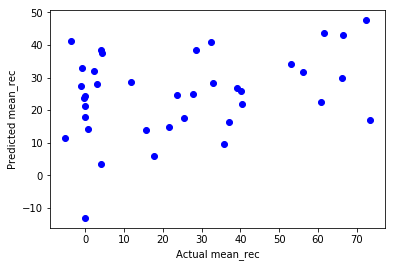

In [18]:
if type_svm == 'nonbinary':
    # Perform the support vector classification
    from nilearn.input_data import NiftiMasker
    from sklearn.feature_selection import f_regression, SelectPercentile
    from sklearn.svm import SVR
    from sklearn.pipeline import Pipeline

    # Set up the regression
    svr = SVR(kernel='linear', C=1)
    masker = NiftiMasker(mask_img=mask,standardize=True, 
                         memory='nilearn_cache', memory_level=1)
    
    feature_selection = SelectPercentile(f_regression, percentile=5)
    fs_svr = Pipeline([('feat_select', feature_selection), ('svr', svr)])
    
    # Run the regression
    X = masker.fit_transform(feature_data)
    X = X
    maskedlabels=labels
    fs_svr.fit(X, maskedlabels)
        
    from sklearn.model_selection import cross_val_predict, LeaveOneOut

    loso = LeaveOneOut()
    y_pred = cross_val_predict(fs_svr, X, y=maskedlabels, n_jobs=6, cv=loso)
    
    # save weights
    coef = svr.coef_
    coef = feature_selection.inverse_transform(coef)
    coef_image = masker.inverse_transform(coef)
    coef_image.to_filename(output_dir + '/svrweights_' + analysis + '.nii.gz')
    
    from scipy.stats import linregress
    slope, intercept, r_val, p_val, stderr = linregress(labels, y_pred) 

    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(labels, y_pred)
    
    from scipy.stats import spearmanr
    spear_r, spear_p = spearmanr(labels, y_pred)

    print("prediction accuracy: %.4f / p-value: %f / MSE: %f // Spearman: %f / p-value: %f" % (r_val, p_val, mse, spear_r, spear_p))

    # plot the predicted versus actual values
    import matplotlib.pyplot as plt
    plt.scatter(labels, y_pred, color='b')
    plt.xlabel('Actual ' + analysis)
    plt.ylabel('Predicted ' + analysis)
    plt.savefig(output_dir + '/scatter_pred_actual_mean_' + analysis + '_final.svg', transparent=True)
    plt.show()
    plt.close()

    results_file.write("MEAN prediction accuracy r-value: %.4f / p-value: %f / MSE: %f // Spearman: %f / p-value: %f \n" % (r_val, p_val, mse, spear_r, spear_p))
    results_file.write('predicted: ' + str(y_pred) + '\n')
    results_file.write('actual: ' + str(labels) + '\n')

    results_file.close()

In [20]:
from sklearn.model_selection import permutation_test_score
import matplotlib.pyplot as plt
from numpy import savetxt

results_file = open(output_dir + '/permut_results_' + analysis + '_final.txt','w')

if type_svm == 'nonbinary':
    ## Perform permutation testing to get a p-value for MSE
    score, permutation_scores, pvalue = permutation_test_score(fs_svr, X, maskedlabels, scoring='neg_mean_squared_error', 
                                                               cv=loso, n_permutations=500, n_jobs=10)
    savetxt(output_dir + '/permutation_scores_mse_' + analysis + '.txt', permutation_scores)

    # Save a figure of the permutation scores
    plt.hist(permutation_scores, 20, label='Permutation scores',
             edgecolor='black')
    ylim = plt.ylim()
    plt.plot(2 * [score], ylim, '--g', linewidth=3,
             label='Mean Squared Error (pvalue %f)' % pvalue)
    plt.ylim(ylim)
    plt.legend()
    plt.xlabel('Score')
    plt.savefig(output_dir + '/permutation_plot_mse_' + analysis + '.svg', transparent=True)
    plt.close()

    # save final pval/classifier score
    results_file.write('MSE score %s (pvalue : %s) \n' % (score, pvalue))
    
    ## Perform permutation testing to get a p-value for r-squared
    score, permutation_scores, pvalue = permutation_test_score(fs_svr, X, maskedlabels, scoring='r2', 
                                                               cv=loso, n_permutations=500, n_jobs=10)
    savetxt(output_dir + '/permutation_scores_r2_' + analysis + '.txt', permutation_scores)

    # Save a figure of the permutation scores
    plt.hist(permutation_scores, 20, label='Permutation scores',
             edgecolor='black')
    ylim = plt.ylim()
    plt.plot(2 * [score], ylim, '--g', linewidth=3,
             label='R-squared (pvalue %f)' % pvalue)
    plt.ylim(ylim)
    plt.legend()
    plt.xlabel('Score')
    plt.savefig(output_dir + '/permutation_plot_r2_' + analysis + '.svg', transparent=True)
    plt.close()

    # save final pval/classifier score
    results_file.write('R square: %s (pvalue : %s) \n' % (score, pvalue))
    results_file.close()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value enc